In [1]:
import sqlite3
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
sns.set_style('white')
sns.set_context('notebook')


conn = sqlite3.connect('./Data/knwlg_blf_controls.db')
dat = pd.read_sql('SELECT * FROM trials A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn)
dat = dat.loc[:,~dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
# REMOVE DISTRACTORS
dat = dat.loc[dat.trial_type == 'test'].reset_index(drop=True)

# Cleaning.
## Make sure correct answer key is accurate

In [2]:
# fix correct answers
dat.loc[dat.belief_type == 'TB', 'correct_answer'] = 'j'
dat.loc[dat.belief_type != 'TB', 'correct_answer'] = 'f'
# update correct column based on new answer key
dat['response_key'] = dat.response_key.apply(literal_eval)
dat['correct'] = dat.apply(lambda row: row['response_key'][-1].lower() == row['correct_answer'], axis=1)
len(dat.prolific_id.unique())

501

### Exclude trials where subjects responded shortly after the 5-second times

In [3]:
# removing weird responses where more than one response and one of them is 999 (timeout)
# this should not be impossible because of the timer. Possibly my fault for not removing keypress event handler at 5 seconds.
# corrected after n=~250, shouldn't make much of a difference since these would be marked incorrect anyway.
weird_resps = dat.loc[(dat.response_key.apply(len)>1) & (dat.apply(lambda row: '999' in row['response_key'], axis=1))].index
dat.drop(weird_resps, inplace=True)
dat = dat.loc[dat.prolific_id !='5e6fd3293c76d25a3ca8b384'] # one weird subject
dat.shape

(5808, 26)

In [4]:
dat.to_csv('./Data/controls_raw.csv', sep=',', header=True)


## Exclude participants with mean accuracy < .6

In [5]:
xx = dat.groupby('prolific_id').correct.mean() >.67
dat = dat.loc[dat.prolific_id.isin(xx[xx ==True].index.tolist())]

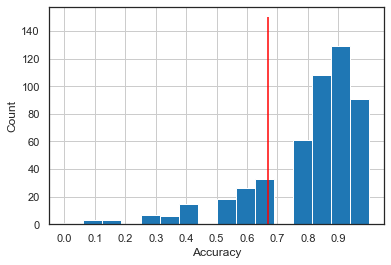

In [21]:
import numpy as np
#xx[xx==False]
#dat.prolific_id.unique()
dat.groupby('prolific_id').correct.mean().hist(bins=16);
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.xticks(np.arange(0, 1, step=0.1))
plt.vlines(.67, ymin=0, ymax=150, colors='red')
plt.savefig('./Figures/cntrl_raw_acc.png', dpi=300.0)

## Convert SQL strings to python datetime object and compute timedeltas

In [6]:
dat['response_onset'] = dat.apply(lambda row: datetime.datetime.strptime(row['response_onset'], '%Y-%m-%d %H:%M:%S.%f'), axis=1)
dat['target_onset'] = dat.apply(lambda row: datetime.datetime.strptime(row['target_onset'], '%Y-%m-%d %H:%M:%S.%f'), axis=1)
dat['rt'] = dat.apply(lambda row: row['response_onset'] - row['target_onset'], axis=1)
dat['rt_ms'] = dat.apply(lambda row: int(round(row['rt'].total_seconds() * 1e3)), axis=1)

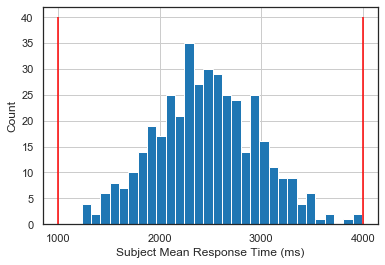

In [12]:
import numpy as np
dat.groupby('prolific_id').rt_ms.mean().hist(bins=30)
plt.xlabel('Subject Mean Response Time (ms)')
plt.ylabel('Count')
plt.xticks(np.arange(0, 6000, step=1000))
plt.vlines(1000, ymin=0, ymax=40, colors='red')
plt.vlines(4000, ymin=0, ymax=40, colors='red')

plt.savefig('./Figures/cntrl_raw_avgRT.png', dpi=300.0)

## Check to make sure all responses came AFTER the target onset

In [7]:
sum(dat.apply(lambda row: row['response_onset'] > row['target_onset'], axis=1)) == len(dat)

True

## Exclude subjects with mean RTs less than 1500ms or more than 4000ms

In [8]:
xx = dat.groupby('prolific_id').rt_ms.mean() < 1000
dat = dat.loc[dat.prolific_id.isin(xx[xx == False].index.tolist())]
yy = dat.groupby('prolific_id').rt_ms.mean() > 4000
dat = dat.loc[dat.prolific_id.isin(yy[yy == False].index.tolist())]
# trial exclusion
dat = dat.loc[(dat.rt_ms > 1000) & (dat.rt_ms < 4500)]

dat.to_csv('./Data/controls.csv', sep=',', header=True)

In [9]:
for old, new in {'IG':'Ignorance', 'TB':'True Info', 'FB':'False Info'}.items():
    dat.belief_type.replace(old, new, inplace=True)

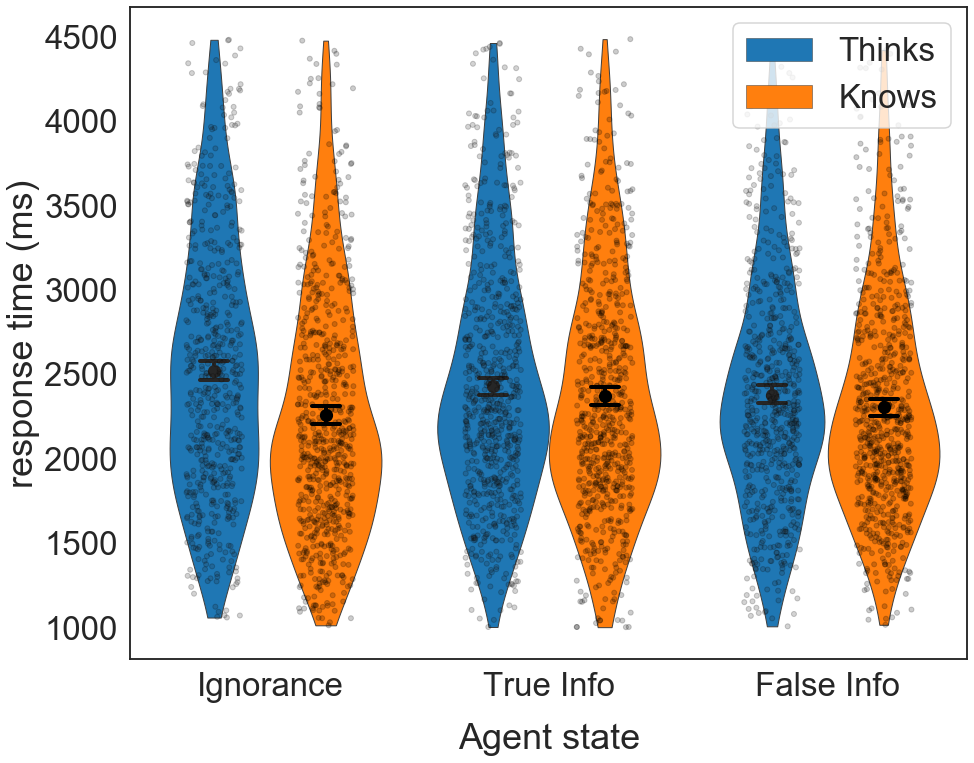

In [18]:
sns.set_context('talk', font_scale=2)
fig, ax = plt.subplots(figsize=(15, 12))
g = sns.violinplot(x='belief_type', y='rt_ms', hue='ascription_type', data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)], cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1)
g = sns.stripplot(x='belief_type', y='rt_ms', hue='ascription_type', data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)],
                  color='k', dodge=True, ax=ax, jitter=.2, linewidth=1, alpha=.2)
g= sns.pointplot(x='belief_type', y='rt_ms', hue='ascription_type', data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)], join=False, dodge=.4, capsize=.1, ax=ax, color='k',)

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
g.yaxis.set_label_text("response time (ms)")
g.xaxis.set_label_text("Agent state")
ax.xaxis.labelpad = 20

#fig.savefig('proposal_S1_control_result.png')

In [20]:
len(dat.prolific_id.unique())

403

# Felicity Judgements

In [10]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
sns.set_style('white')
sns.set_context('notebook')


#conn = sqlite3.connect('knwlg_blf.db')
f_dat = pd.read_sql('SELECT * FROM felicities A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn)
f_dat = f_dat.loc[:,~f_dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate

# 1= "Sounds very weird"
# 7 = "Sounds very normal"
f_dat['Infelicity Rating'] = 8 - f_dat.felicity_rating

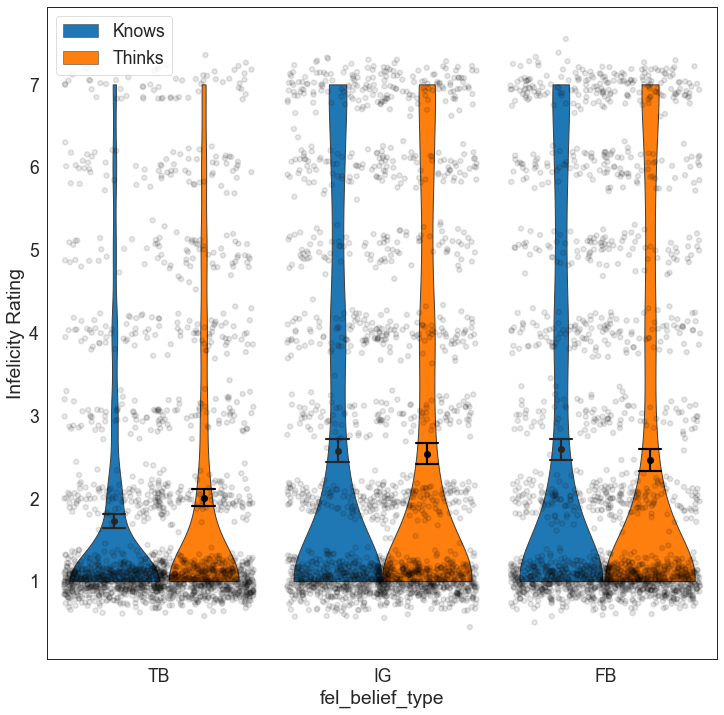

In [14]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(12,12))
g = sns.violinplot(x='fel_belief_type', y='Infelicity Rating', hue='fel_ascription_type', data=f_dat, cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1, order=['TB', 'IG', 'FB'])

def jitter(values,j):
    return values + np.random.normal(j,0.15,values.shape)

g = sns.stripplot(x='fel_belief_type', y=jitter(f_dat['Infelicity Rating'], 0), hue='fel_ascription_type', data=f_dat,
                  color='k', dodge=True, ax=ax, jitter=.45, linewidth=1.5, alpha=.1, order=['TB', 'IG', 'FB'])
g= sns.pointplot(x='fel_belief_type', y='Infelicity Rating', hue='fel_ascription_type', data=f_dat, join=False, dodge=.4, capsize=.1, ax=ax, color='k',order=['TB', 'IG', 'FB'])

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])

#fig.savefig('control_fel.png')

In [15]:
len(f_dat.prolific_id.unique())

501

# Demographics

In [30]:
len(dat.prolific_id.unique())

403

In [11]:
import sqlite3
import pandas as pd
import datetime
import seaborn as sns
from ast import literal_eval
sns.set_style('white')
sns.set_context('notebook')


#conn = sqlite3.connect('knwlg_blf_controls.db')
demos = pd.read_sql('SELECT * FROM demographics A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn)
demos = demos.loc[:,~demos.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate

subjects = dat.prolific_id.unique()
demos = demos[demos.prolific_id.isin(subjects).values] # only use subjects in trial analysis
demos.education.describe()

count                          403
unique                           9
top       College Graduate(4 year)
freq                           156
Name: education, dtype: object

In [12]:
sns

403

# AQ-10

In [17]:

import numpy as np

conn = sqlite3.connect('knwlg_blf.db')
a_dat = pd.read_sql('SELECT * FROM autism_scores A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn)
a_dat = a_dat.loc[:,~a_dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate

a_dat = a_dat[a_dat.prolific_id.isin(dat.prolific_id.unique()).values] # only use subjects in trial analysis
a_dat.describe()

,id,AQ_rating_1,AQ_rating_2,AQ_rating_3,AQ_rating_4,AQ_rating_5,AQ_rating_6,AQ_rating_7,AQ_rating_8,AQ_rating_9,AQ_rating_10,block1_complete,block2_complete,block3_complete
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.0,422.0,422.0
mean,286.398104,2.838863,2.635071,2.511848,2.763033,3.026066,3.277251,1.838863,2.597156,2.917062,2.099526,1.0,1.0,1.0
std,162.781268,0.938795,0.860593,0.918846,0.925109,0.902245,0.842124,0.793445,0.964349,0.861001,0.843896,0.0,0.0,0.0
min,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
25%,145.250000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,1.000000,2.000000,2.000000,2.000000,1.0,1.0,1.0
50%,281.500000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.0,1.0,1.0
75%,423.750000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000,2.000000,3.000000,4.000000,3.000000,1.0,1.0,1.0
max,567.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.0,1.0,1.0


## scoring

In [18]:
## Scoring
agree = ['AQ_rating_1', 'AQ_rating_7', 'AQ_rating_8', 'AQ_rating_10'] # score of 3 or 4 get a point
disagree = ['AQ_rating_2','AQ_rating_3','AQ_rating_4','AQ_rating_5','AQ_rating_6','AQ_rating_9', ] # score of 1 or 2 get a point]
a = a_dat[agree] >= 3
b = a_dat[disagree] < 3
a_dat['AQ_score'] = a.sum(axis=1) + b.sum(axis=1)

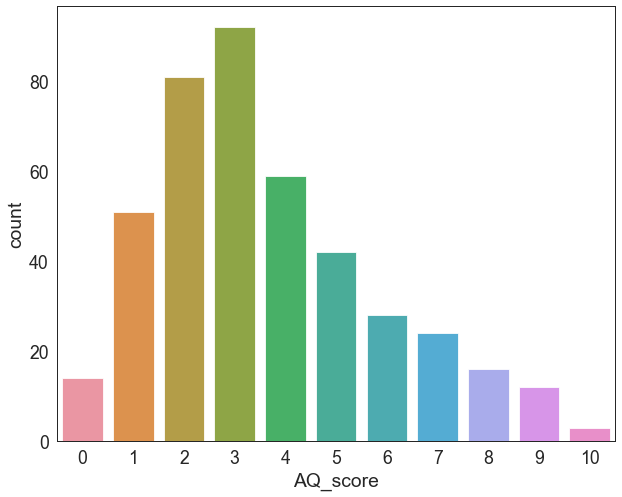

In [19]:

sns.set_context('paper', font_scale=2)
fg, ax = plt.subplots(figsize=(10, 8))
sns.countplot(data=a_dat, x='AQ_score', ax=ax)
#plt.savefig('control_aq_score.png')

In [20]:
a_dat.groupby('AQ_score').count()

,id,AQ_rating_1,AQ_rating_2,AQ_rating_3,AQ_rating_4,AQ_rating_5,AQ_rating_6,AQ_rating_7,AQ_rating_8,AQ_rating_9,...,screen_width,screen_height,operating_sys,operating_sys_lang,GMT_timestamp,block1_complete,block2_complete,block3_complete,completion_code,feedback
AQ_score,,,,,,,,,,,,,,,,,,,,,
0,14,14,14,14,14,14,14,14,14,14,...,0,0,0,0,14,14,14,14,14,14
1,51,51,51,51,51,51,51,51,51,51,...,0,0,0,0,51,51,51,51,51,51
2,81,81,81,81,81,81,81,81,81,81,...,0,0,0,0,81,81,81,81,81,81
3,92,92,92,92,92,92,92,92,92,92,...,0,0,0,0,92,92,92,92,92,92
4,59,59,59,59,59,59,59,59,59,59,...,0,0,0,0,59,59,59,59,59,59
5,42,42,42,42,42,42,42,42,42,42,...,0,0,0,0,42,42,42,42,42,42
6,28,28,28,28,28,28,28,28,28,28,...,0,0,0,0,28,28,28,28,28,28
7,24,24,24,24,24,24,24,24,24,24,...,0,0,0,0,24,24,24,24,24,24
8,16,16,16,16,16,16,16,16,16,16,...,0,0,0,0,16,16,16,16,16,16


## AQ-10 and Knowledge/Belief Reaction Time Differences

In [21]:
cdat = dat.loc[dat.correct ==True]
for subject in subjects:
    # calculate mean RT for belief ascription
    a_dat.loc[a_dat.prolific_id == subject, 'avg_ThinkRT'] = cdat.loc[(cdat.prolific_id == subject) & (cdat.ascription_type == 'Thinks')].rt_ms.mean()
    a_dat.loc[a_dat.prolific_id == subject, 'avg_KnowRT'] = cdat.loc[(cdat.prolific_id == subject) & (cdat.ascription_type == 'Knows')].rt_ms.mean()

a_dat['RT_diff'] = a_dat.apply(lambda row: row['avg_ThinkRT'] - row['avg_KnowRT'], axis=1)


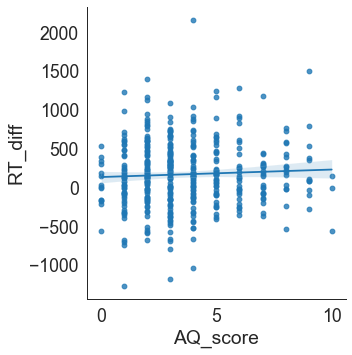

In [22]:
from scipy.stats.stats import pearsonr
pearsonr(a_dat.AQ_score, a_dat.RT_diff)

sns.lmplot(x='AQ_score', y='RT_diff', data=a_dat);


In [23]:
from pymer4 import Lm

Lm('RT_diff ~ AQ_score', data=a_dat).fit()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


Formula: RT_diff~AQ_score

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 422	 R^2: 0.003	 R^2_adj: 0.000

Log-likelihood: -3147.176 	 AIC: 6298.353	 BIC: 6306.443

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,136.063,58.764,213.363,39.326,420,3.460,0.001,***
AQ_score,9.652,-8.471,27.775,9.220,420,1.047,0.296,


ValueError: Could not interpret input 'AQ_item'

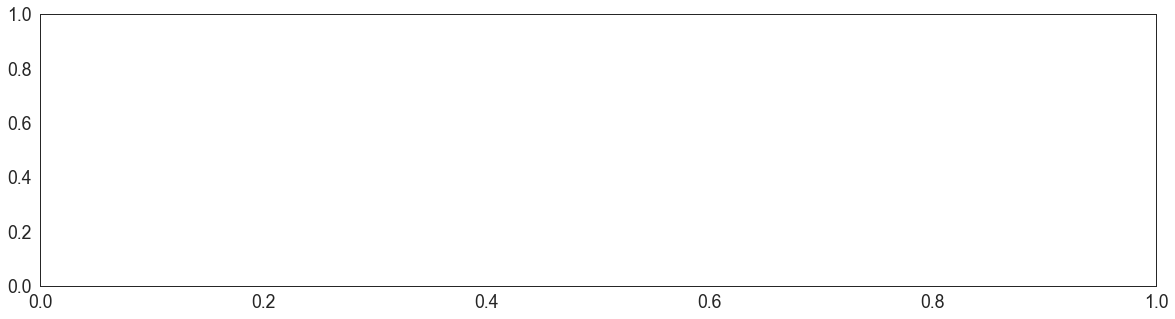

In [25]:
items = ["I often notice small sounds when others do not.",
                 "I usually concentrate more on the whole picture rather than the small details.",
                 "I find it easy to do more than one thing at once.",
                 "If there is an interruption, I can switch back to what I was doing very quickly.",
                 "I find it easy to “read between the lines” when someone is talking to me.",
                 "I know how to tell if someone listening to me is getting bored.",
                 "When I’m reading a story I find it difficult to work out the characters’ intentions.",
                 "I like to collect information about characters of things (e.g. types of car, types of bird, types of train, types of plant, etc.)",
                 "I find it easy to work out what someone is thinking or feeling just by looking at their face.",
                 "I find it difficult to work out people’s intentions."]


sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(20,5))
g = sns.violinplot(x='AQ_item', y='rating', data=a_dat, cut=0, ax=ax, inner=None, linewidth=1, saturation=1)

def jitter(values,j):
    return values + np.random.normal(j,0.15,values.shape)

g = sns.stripplot(x='AQ_item', y=jitter(aa['rating'], 0), data=aa,
                  color='k', dodge=True, ax=ax, jitter=.45, linewidth=1.5, alpha=.1)

g= sns.pointplot(x='AQ_item', y='rating', data=aa, join=False, dodge=.4, capsize=.1, ax=ax, color='k',)
ax.set_yticklabels(['','Definitely Disagree', 'Slightly Disagree', 'Slightly Agree', 'Definitely Agree'])
ax.set_xticklabels(items, rotation=15, fontdict={'fontsize': 13,'horizontalalignment': 'right'})

#ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])

#fig.savefig('control_aq_10.png', bbox_inches='tight')

# Statistics

In [26]:
from tqdm import tqdm

cols = ['prolific_id', 'scenario', 'ascription', 'belief', 'rt', 'felicity']
sdat = pd.DataFrame(columns=cols)
for subject in tqdm(list(dat.prolific_id.unique())):
   for scene in list(range(1,13)):
       t = dat.loc[(dat.prolific_id == subject) & (dat.scenario == int(scene))]
       f = f_dat.loc[(f_dat.prolific_id == subject) & (f_dat.fel_scenario == scene)]
       if len(t) == len(f) == 1:
        row_vals = [t.prolific_id.values[0], scene, t.ascription_type.values[0], t.belief_type.values[0], t.rt_ms.values[0], f['Infelicity Rating'].values[0]]
        sdat = sdat.append(pd.DataFrame([row_vals],columns=cols))


100%|██████████| 422/422 [00:30<00:00, 13.64it/s]


In [32]:
from pymer4 import Lmer

m1 = Lmer("rt ~ ascription + belief + felicity + (ascription + belief|prolific_id) + (1|scenario)", data=sdat)
m2 = Lmer("rt ~  belief + felicity + (ascription + belief|prolific_id) + (1|scenario)", data=sdat)
m1.fit(factors={"ascription":["Thinks", "Knows"], "belief":["TB", "FB", "IG"], "scenario":['1','2','3','4','5', '6', '7', '8', '9', '10', '11', '12']}, summarize=False, REML=False)
m2.fit(factors={"ascription":["Thinks", "Knows"], "belief":["TB", "FB", "IG"], "scenario":['1','2','3','4','5', '6', '7', '8', '9', '10', '11', '12']}, summarize=False, REML=False)
mc = Lmer.anova(m1, m2)
mc.iloc[:]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


boundary (singular) fit: see ?isSingular 

Model failed to converge with max|grad| = 0.00232913 (tol = 0.002, component 1) 

boundary (singular) fit: see ?isSingular 

boundary (singular) fit: see ?isSingular 

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Model refit with orthogonal polynomial contrasts)


,SS,MS,NumDF,DenomDF,F-stat,P-val,Sig
ascription,4.902153e+07,4.902153e+07,1,3367.755401,113.796745,3.758295e-26,***
belief,1.317535e+06,6.587676e+05,2,422.875093,1.529239,2.178965e-01,
felicity,3.552867e+05,3.552867e+05,1,4077.590290,0.824749,3.638489e-01,


In [35]:
m3 = Lmer("rt ~ ascription + belief + felicity + (ascription + belief|prolific_id) + (ascription + belief|scenario)", data=sdat)
m3.fit(factors={"ascription":["Thinks", "Knows"], "belief":["TB", "FB", "IG"], "scenario":['1','2','3','4','5', '6', '7', '8', '9', '10', '11', '12']}, summarize=False, REML=False)
Lmer.anova(m2, m3)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


boundary (singular) fit: see ?isSingular 

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Model refit with orthogonal polynomial contrasts)


,SS,MS,NumDF,DenomDF,F-stat,P-val,Sig
belief,1.641867e+06,820933.497341,2,430.413323,1.934449,0.145758,
felicity,4.247348e+05,424734.758790,1,4122.252630,1.000845,0.317165,


In [34]:
m3.summary()

Formula: rt~ascription+belief+felicity+(ascription+belief|prolific_id)+(ascription+belief|scenario)

Family: gaussian	 Inference: parametric

Number of observations: 4944	 Groups: {'prolific_id': 422.0, 'scenario': 12.0}

Log-likelihood: -39525.502 	 AIC: 79103.003

Random effects:

Empty DataFrame
Columns: [Name, Var, Std]
Index: []

                         IV1              IV2     Corr
prolific_id      (Intercept)             None  475.237
prolific_id  ascriptionKnows             None  142.507
prolific_id         beliefFB             None  187.298
prolific_id         beliefIG             None  203.347
prolific_id      (Intercept)  ascriptionKnows   -0.284
prolific_id      (Intercept)         beliefFB   -0.216
prolific_id      (Intercept)         beliefIG   -0.083
prolific_id  ascriptionKnows         beliefFB   -0.269
prolific_id  ascriptionKnows         beliefIG   -0.052
prolific_id         beliefFB         beliefIG    0.730
scenario         (Intercept)             None  296.758
sce

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),2610.982,2432.079,2789.886,91.279,13.967,28.604,0.000,***
ascriptionKnows,-206.092,-269.803,-142.382,32.506,13.072,-6.340,0.000,***
beliefFB,-12.209,-103.416,78.998,46.535,12.368,-0.262,0.797,
beliefIG,27.810,-53.424,109.045,41.447,12.801,0.671,0.514,
felicity,5.098,-6.524,16.720,5.930,4140.436,0.860,0.390,


# Time out rates

In [14]:
dat[['999' in x for x in dat.response_key]]

,id,trial_num,correct,trial_type,scenario,belief_type,ascription_type,correct_answer,target_onset,response_onset,...,operating_sys,operating_sys_lang,GMT_timestamp,block1_complete,block2_complete,block3_complete,completion_code,feedback,rt,rt_ms
36,145,1,False,test,5,True Info,Thinks,j,2022-06-18 11:38:27.842,2022-06-18 11:38:32.937,...,None,None,2022-06-18 15:35:33.953176,1,1,1,548DA3BD,None,0 days 00:00:05.095000,5095
38,148,4,False,test,4,False Info,Thinks,f,2022-06-18 11:39:57.437,2022-06-18 11:40:02.534,...,None,None,2022-06-18 15:35:33.953176,1,1,1,548DA3BD,None,0 days 00:00:05.097000,5097
43,154,10,False,test,8,Ignorance,Thinks,f,2022-06-18 11:43:23.652,2022-06-18 11:43:28.753,...,None,None,2022-06-18 15:35:33.953176,1,1,1,548DA3BD,None,0 days 00:00:05.101000,5101
159,489,9,False,test,1,True Info,Thinks,j,2022-06-21 11:27:12.895,2022-06-21 11:27:18.005,...,None,None,2022-06-21 15:21:25.642156,1,1,1,548DA3BD,"I did not like the game, I found it hard to re...",0 days 00:00:05.110000,5110
268,732,12,False,test,6,True Info,Thinks,j,2022-06-21 11:46:12.601,2022-06-21 11:46:17.702,...,None,None,2022-06-21 15:39:09.559565,1,1,1,548DA3BD,I don't know who designed this study but the w...,0 days 00:00:05.101000,5101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,12529,1,False,test,8,True Info,Knows,j,2022-06-22 20:36:15.385,2022-06-22 20:36:20.484,...,None,None,2022-06-23 00:32:35.223782,1,1,1,548DA3BD,It was an interesting game and I did not reall...,0 days 00:00:05.099000,5099
5500,12560,8,False,test,4,Ignorance,Knows,f,2022-06-22 20:39:33.021,2022-06-22 20:39:38.116,...,None,None,2022-06-23 00:33:08.455255,1,1,1,548DA3BD,,0 days 00:00:05.095000,5095
5610,12782,14,False,test,6,Ignorance,Thinks,f,2022-06-22 20:43:55.647,2022-06-22 20:44:00.746,...,None,None,2022-06-23 00:35:36.408976,1,1,1,548DA3BD,I just went with how I felt. The second part w...,0 days 00:00:05.099000,5099
5812,13207,7,False,test,5,True Info,Thinks,j,2022-06-22 20:44:11.205,2022-06-22 20:44:16.308,...,None,None,2022-06-23 00:39:41.600827,1,1,1,548DA3BD,N/A,0 days 00:00:05.103000,5103


In [17]:
len(dat[['999' in x for x in dat.response_key]])/(len(dat.prolific_id.unique()) *12)

0.017772511848341232